Entrenando la red neuronal, espere
Iter 0 - Loss: 0.6931, Acc Train: 0.3438, Acc Val: 0.4788
Iter 1000 - Loss: 0.6932, Acc Train: 0.5000, Acc Val: 0.4988
Iter 2000 - Loss: 0.6934, Acc Train: 0.4375, Acc Val: 0.5012
Iter 3000 - Loss: 0.6927, Acc Train: 0.5625, Acc Val: 0.4988
Iter 4000 - Loss: 0.6922, Acc Train: 0.5938, Acc Val: 0.5012
Iter 5000 - Loss: 0.6932, Acc Train: 0.4688, Acc Val: 0.4988
Iter 6000 - Loss: 0.6939, Acc Train: 0.4062, Acc Val: 0.4988
Iter 7000 - Loss: 0.6923, Acc Train: 0.6250, Acc Val: 0.4988
Iter 8000 - Loss: 0.6949, Acc Train: 0.4062, Acc Val: 0.4988
Iter 9000 - Loss: 0.6926, Acc Train: 0.5312, Acc Val: 0.4988
Iter 10000 - Loss: 0.6925, Acc Train: 0.5312, Acc Val: 0.5012
Iter 11000 - Loss: 0.6935, Acc Train: 0.4688, Acc Val: 0.4988
Iter 12000 - Loss: 0.6947, Acc Train: 0.3438, Acc Val: 0.4988
Iter 13000 - Loss: 0.6931, Acc Train: 0.5000, Acc Val: 0.4988
Iter 14000 - Loss: 0.6919, Acc Train: 0.5625, Acc Val: 0.5012
Iter 15000 - Loss: 0.6925, Acc Train: 0.5625, Ac

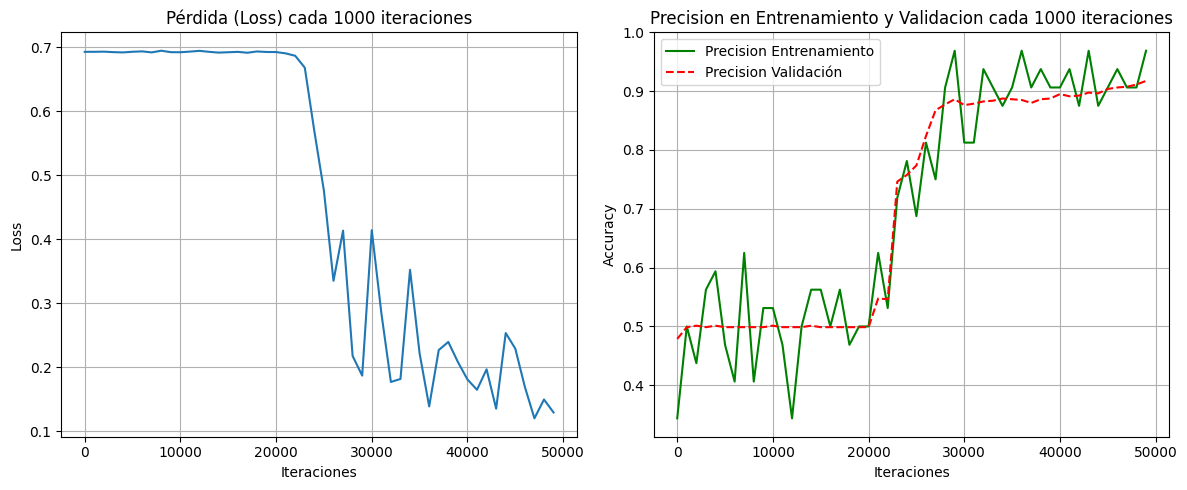

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import time

# --------------------------------------------
# CARGA Y PREPROCESAMIENTO
# --------------------------------------------
df_processed = pd.read_csv("apple_actualizado.csv")

X = df_processed[['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness', 'Acidity']].values
y = df_processed['Quality_numeric'].values.reshape(-1, 1) # para convertir el vector de etiquetas en una matriz columna

#normalizo
scaler = StandardScaler()
X = scaler.fit_transform(X)

#divido entre datos para entrenar y datos para evaluar(80/20). 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# --------------------------------------------
# FUNCIONES DE ACTIVACIÓN Y PESOS
# --------------------------------------------
#transformo en un valor entre 0 y 1
def sigmoid(x): return 1 / (1 + np.exp(-x))
#calculo la derivada para ajustar los pesos en el entrenamiento
def sigmoid_deriv(x): s = sigmoid(x); return s * (1 - s)

#devuelve el mismo numero si es positivo, y 0 si es negativo
def relu(x): return np.maximum(0, x)
def relu_deriv(x): return (x > 0).astype(float)
#tema derivadas), si es grande el error cambia mucho, entonces hay q ajustar mas ese peso

def init_pesos(input_dim, h1=16, h2=8, output_dim=1):
    np.random.seed(0)#genero aleatorios para eivtar q el modelo aprenda con la misma info en todas tipo d memoria
    return (
        np.random.randn(input_dim, h1) * 0.01, np.zeros((1, h1)), #capa1
        np.random.randn(h1, h2) * 0.01, np.zeros((1, h2)),#capa2
        np.random.randn(h2, output_dim) * 0.01, np.zeros((1, output_dim))#capa3
    )
#para obtener salidas
def forward(X, W1, b1, W2, b2, W3, b3):
    Z1 = X @ W1 + b1
    A1 = relu(Z1)
    Z2 = A1 @ W2 + b2
    A2 = relu(Z2)
    Z3 = A2 @ W3 + b3
    A3 = sigmoid(Z3)
    return Z1, A1, Z2, A2, Z3, A3

# --------------------------------------------
# ENTRENAMIENTO CON MINI-BATCH - 50.000 ITERACIONES
# --------------------------------------------
#entreno mediante backpropagation con minibatch
#se actualizan los pesos en cada iteración utilizando el gradiente descendente
def entrenar_con_iteraciones(X, y, X_val, y_val, iteraciones=50000, batch_size=32, lr=0.01):
    W1, b1, W2, b2, W3, b3 = init_pesos(X.shape[1])#inicializo pesos y sesgos
    loss_hist, acc_train_hist, acc_val_hist = [], [], []#histroial de perdidas y presiciom

    for it in range(iteraciones):
        ## Selecciona un mini-batch aleatorio
        idx = np.random.choice(len(X), size=batch_size, replace=False)
        Xb = X[idx]
        yb = y[idx]

        Z1, A1, Z2, A2, Z3, A3 = forward(Xb, W1, b1, W2, b2, W3, b3)
        loss = -np.mean(yb * np.log(A3 + 1e-8) + (1 - yb) * np.log(1 - A3 + 1e-8))
        acc_train = accuracy_score(yb, (A3 > 0.5).astype(int))

        if it % 1000 == 0:
            # Evaluar en conjunto de validación cada 1000 it
            _, _, _, _, _, val_preds = forward(X_val, W1, b1, W2, b2, W3, b3)
            acc_val = accuracy_score(y_val, (val_preds > 0.5).astype(int))

            loss_hist.append(loss)
            acc_train_hist.append(acc_train)
            acc_val_hist.append(acc_val)

            print(f"Iter {it} - Loss: {loss:.4f}, Acc Train: {acc_train:.4f}, Acc Val: {acc_val:.4f}")

        # Backpropagation 
        #capa3
        dZ3 = A3 - yb#derivada de la salida
        dW3 = A2.T @ dZ3 / batch_size#gradiente d pesos
        db3 = np.sum(dZ3, axis=0, keepdims=True) / batch_size#gradiente del sesgo
        
        #capa2
        dA2 = dZ3 @ W3.T
        dZ2 = dA2 * relu_deriv(Z2)
        dW2 = A1.T @ dZ2 / batch_size
        db2 = np.sum(dZ2, axis=0, keepdims=True) / batch_size
        
        #capa1
        dA1 = dZ2 @ W2.T
        dZ1 = dA1 * relu_deriv(Z1)
        dW1 = Xb.T @ dZ1 / batch_size
        db1 = np.sum(dZ1, axis=0, keepdims=True) / batch_size
#actualizo con gradiente descendente
        W3 -= lr * dW3
        b3 -= lr * db3
        W2 -= lr * dW2
        b2 -= lr * db2
        W1 -= lr * dW1
        b1 -= lr * db1

    return W1, b1, W2, b2, W3, b3, loss_hist, acc_train_hist, acc_val_hist

# --------------------------------------------
# ENTRENAR Y EVALUAR
# --------------------------------------------
print("Entrenando la red neuronal, espere")
start = time.time() # calculo el tiempo con esto
W1, b1, W2, b2, W3, b3, losses, accs_train, accs_val = entrenar_con_iteraciones(X_train, y_train, X_val, y_val)

# prediccion de entrenamiento y validacion
train_preds = forward(X_train, W1, b1, W2, b2, W3, b3)[-1]
val_preds = forward(X_val, W1, b1, W2, b2, W3, b3)[-1]

#precision 
train_acc = accuracy_score(y_train, (train_preds > 0.5).astype(int))
val_acc = accuracy_score(y_val, (val_preds > 0.5).astype(int))

#.astype(int) convierte los valores booleanos en enteros, donde True se convierte en 1 y False en 0.
#a salida de la red (train_preds) es una probabilidad entre 0 y 1 (debido a la función sigmoide)

print("\n--- Resultados ---")
print(f"Precision en entrenamiento: {train_acc:.4f}")
print(f"Precision en validación: {val_acc:.4f}")
print(f"Tiempo total de entrenamiento: {time.time() - start:.2f} segundos") # Detiene y muestra el cronómetro

# --------------------------------------------
# GRÁFICAS
# --------------------------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(np.arange(0, 50000, 1000), losses)
plt.title("Pérdida (Loss) cada 1000 iteraciones")
plt.xlabel("Iteraciones")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)

plt.plot(np.arange(0, 50000, 1000), accs_train, label='Precision Entrenamiento', color='green')
plt.plot(np.arange(0, 50000, 1000), accs_val, label='Precision Validación', color='red', linestyle='--')
plt.title("Precision en Entrenamiento y Validacion cada 1000 iteraciones")
plt.xlabel("Iteraciones")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

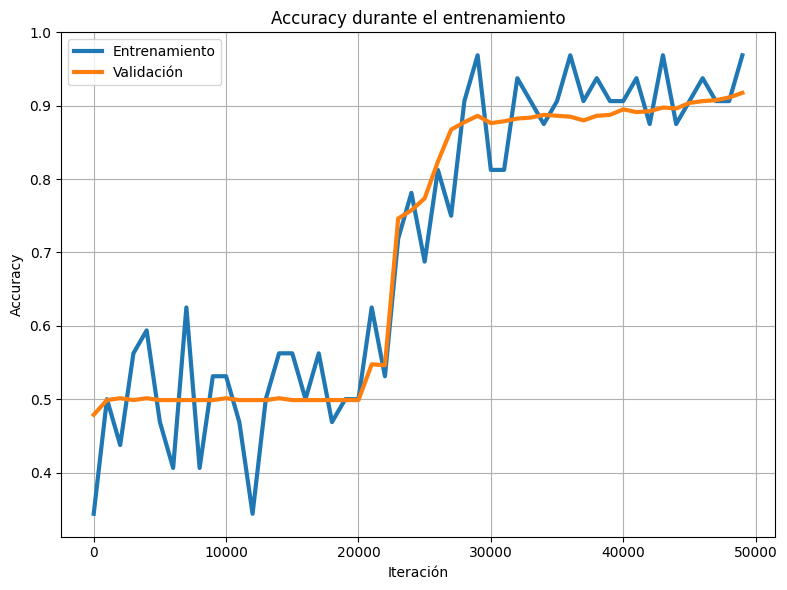

In [9]:
fmt_train = {'color': 'tab:blue', 'ls': 'solid', 'lw': 3}
fmt_val = {'color': 'tab:orange', 'ls': 'solid', 'lw': 3}

steps = np.arange(0, 50000, 1000)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(steps, accs_train, label='Entrenamiento', **fmt_train)
ax.plot(steps, accs_val, label='Validación', **fmt_val)

ax.grid(True)
ax.legend()
ax.set_title('Accuracy durante el entrenamiento')
ax.set_xlabel('Iteración')
ax.set_ylabel('Accuracy')
fig.tight_layout()
plt.show()


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import time

mlp = MLPClassifier(hidden_layer_sizes=(16, 8), activation='relu', solver='sgd',
                    learning_rate_init=0.01, max_iter=50000, random_state=42, verbose=False)

print("Entrenando red neuronal con scikit-learn...")
start_skl = time.time()
mlp.fit(X_train, y_train.ravel()) # .ravel() para convertir y_train a un array 1D
end_skl = time.time()
print(f"Tiempo total de entrenamiento con scikit-learn: {end_skl - start_skl:.2f} segundos")

# Predecir y evaluar
y_train_pred_skl = mlp.predict(X_train)
y_val_pred_skl = mlp.predict(X_val)

train_acc_skl = accuracy_score(y_train, y_train_pred_skl)
val_acc_skl = accuracy_score(y_val, y_val_pred_skl)

print("\n--- Resultados scikit-learn ---")
print(f"Precision en entrenamiento (scikit-learn): {train_acc_skl:.4f}")
print(f"Precision en validación (scikit-learn): {val_acc_skl:.4f}")

Entrenando red neuronal con scikit-learn...
Tiempo total de entrenamiento con scikit-learn: 2.00 segundos

--- Resultados scikit-learn ---
Precision en entrenamiento (scikit-learn): 0.9478
Precision en validación (scikit-learn): 0.9325
